In [1]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from math import sqrt
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [3]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [4]:
# Define the selected exogenous variables and target variable.
features = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]
target = df1['Close']

In [5]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Initialize and fit RobustScalers to scale data with reduced sensitivity to outliers.
scaler_X = RobustScaler()
scaler_y = RobustScaler()

# Fit scalers on training data and transform both training and test data.
X_train_scaled = scaler_X.fit_transform(X_train) # Fit scaler on training features and transform.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) # Fit scaler on training target and transform.

# Transform test data without fitting again to avoid data leakage.
X_test_scaled = scaler_X.transform(X_test) # Transform test features using the scaler fitted on training data.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) # Transform test target using the scaler fitted on training data

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Features - Min:", X_train_scaled.min(), "Max:", X_train_scaled.max())
print("Scaled Training Target - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Features - Min:", X_test_scaled.min(), "Max:", X_test_scaled.max())
print("Scaled Test Target - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Features - Min: -5.403959826651211 Max: 27.13019517164182
Scaled Training Target - Min: -3.6389567455761282 Max: 2.3883417923341392
Scaled Test Features - Min: -3.6389567455761282 Max: 79.04390234398078
Scaled Test Target - Min: -3.6389567455761282 Max: 2.3883417923341392


## Sequence Length = 4 

In [158]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 4  # Number of time steps used for target prediction, 4 weeks.

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (872, 4, 5)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 5)
Reshaped  y_test_seq shape: (151, 1)


### Random Parameters. (Model 1)

In [8]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define hyperparameters
dropout_rate = 0.3          # Dropout rate to help prevent overfitting by randomly dropping nodes during training.
l2_lambda = 0.01            # L2 regularization factor, penalizes large weights and attempt to prevent overfitting.
learning_rate = 0.0002      # Learning rate for the optimizer to control how much to adjust weights during backpropagation.
epochs = 50                 # Maximum number of training epochs.
batch_size = 128            # Batch size for each training step, determines how many samples are used in each gradient update.

# Initialize the LSTM model.
model = Sequential()

# First LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units (neurons) in the layer.
               return_sequences=True,       # Ensures that the layer returns the entire sequence for the next LSTM layer.
               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape: (sequence length, number of features).
               kernel_regularizer=l2(l2_lambda)))  # Applies L2 regularization to reduce overfitting.
model.add(Dropout(dropout_rate))            # Adds dropout layer to reduce overfitting by randomly setting some neurons to 0.

# Second LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units in the second layer.
               return_sequences=False,      # Last LSTM layer should not return sequences; it outputs only the final state.
               kernel_regularizer=l2(l2_lambda)))  # L2 regularization to prevent overfitting.
model.add(Dropout(dropout_rate))            # Dropout for regularization.

# Output layer
model.add(Dense(1))                         # Dense layer with a single unit, since its predicting a single value (regression).

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with a specified learning rate.
              loss='mean_squared_error')                    # Mean Squared Error (MSE) as the loss function for regression.

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',          # Monitor validation loss to stop if it stops improving.
                               patience=10,                 # Wait for 10 epochs with no improvement before stopping.
                               restore_best_weights=True)   # Restore model weights from the epoch with the lowest validation loss.

# Train the model
history = model.fit(X_train_seq, y_train_seq,               # Training data (features and target).
                    epochs=epochs,                          # Maximum number of epochs.
                    batch_size=batch_size,                  # Batch size.
                    validation_data=(X_test_seq, y_test_seq),  # Validation data to monitor overfitting.
                    callbacks=[early_stopping],             # Callback for early stopping. 
                    shuffle=False,
                    verbose=1)                              # Verbose output for progress during training.

# Print final training and validation loss values.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.1039 - val_loss: 2.1881
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0671 - val_loss: 2.1574
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0464 - val_loss: 2.1271
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0166 - val_loss: 2.0979
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9850 - val_loss: 2.0699
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9511 - val_loss: 2.0425
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9218 - val_loss: 2.0160
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8952 - val_loss: 1.9905
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8727 - val_loss: 1.9657
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8447 - val_loss: 1.9418
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8206 - val_loss: 1.9185
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8062 - val_loss: 1.8958
Epoch 13/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
LSTM Model Performance:
Training RMSE: 0.020274764054727078
Test RMSE: 0.023086916831245
Training MAE: 0.014680984858060181
Test MAE: 0.01751282042353632
Directional Accuracy on Training Data: 52.69804822043628%
Directional Accuracy on Test Data: 50.0%


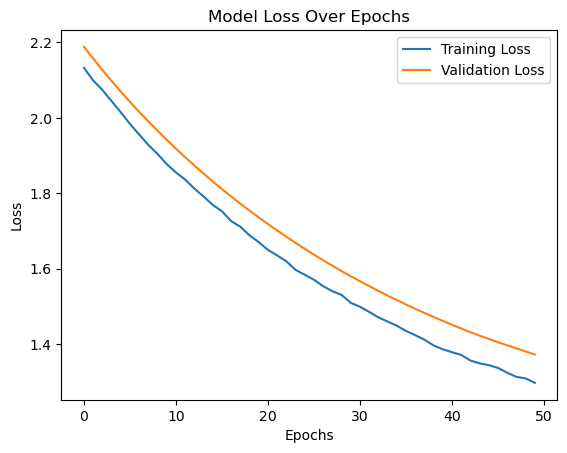

In [9]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2

In [10]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'huber_loss',
    'learning_rate_decay': 1e-6,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 150,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False,
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.2901 - val_loss: 1.4815
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3323 - val_loss: 1.4762
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2903 - val_loss: 1.4755
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1210 - val_loss: 1.4726
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9361 - val_loss: 1.4758
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8143 - val_loss: 1.4721
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7270 - val_loss: 1.4700
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6844 - val_loss: 1.4662
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6973 - val_loss: 1.4605
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6083 - val_loss: 1.4599
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4526 - val_loss: 1.4552
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.019779049249180322
Test RMSE: 0.02305397912859761
Training MAE: 0.014436499632729577
Test MAE: 0.017417663224331977
Directional Accuracy on Training Data: 59.35706084959816%
Directional Accuracy on Test Data: 54.0%


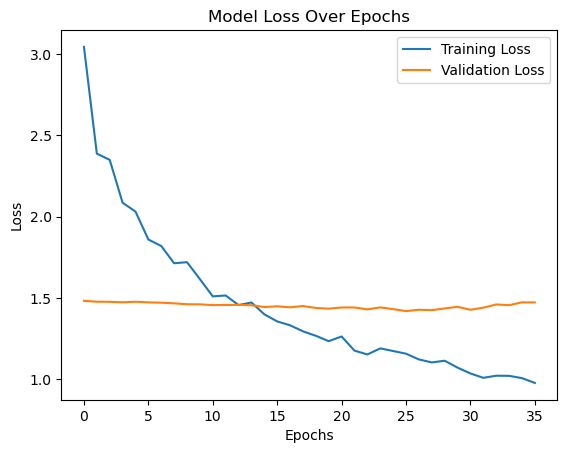

In [11]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1.Random Search 

### Two Layers (Model 3)

In [14]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.2684329748153687
Final Validation Loss: 1.5459833145141602
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.166832685470581
Final Validation Loss: 2.164638042449951
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 0.871383786201477
Final Validation Loss: 1.2956427335739136
Running combination 4/3

In [170]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.2,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.0412 - val_loss: 1.1357
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0131 - val_loss: 1.1372
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0109 - val_loss: 1.1347
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0093 - val_loss: 1.1329
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8006 - val_loss: 1.1335
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6778 - val_loss: 1.1342
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5181 - val_loss: 1.1349
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5930 - val_loss: 1.1360
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5943 - val_loss: 1.1362
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6659 - val_loss: 1.1358
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6298 - val_loss: 1.1362
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5396 - val_loss: 1.1366
Epoch 13/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.02032932437319742
Test RMSE: 0.02303948770585692
Training MAE: 0.01465956281891247
Test MAE: 0.017431239493461866
Directional Accuracy on Training Data: 51.77956371986223%
Directional Accuracy on Test Data: 46.0%


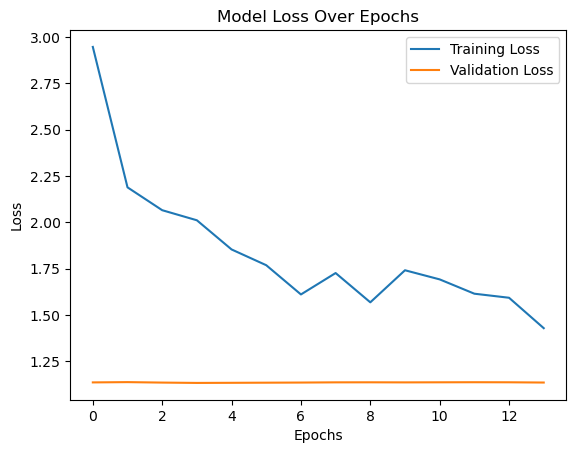

In [172]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 4)

In [18]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0359541177749634
Final Validation Loss: 1.44378662109375
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.07795524597168
Final Validation Loss: 3.9964523315429688
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.599644422531128
Final Validatio

In [174]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.0075 - val_loss: 1.2691
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1442 - val_loss: 1.2678
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0451 - val_loss: 1.2671
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7848 - val_loss: 1.2670
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9368 - val_loss: 1.2672
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7208 - val_loss: 1.2676
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7061 - val_loss: 1.2671
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6806 - val_loss: 1.2664
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5883 - val_loss: 1.2667
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6840 - val_loss: 1.2660
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5855 - val_loss: 1.2659
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4884 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.01882954153953576
Test RMSE: 0.022622831098212382
Training MAE: 0.01355491546802285
Test MAE: 0.01727320165237998
Directional Accuracy on Training Data: 59.70149253731343%
Directional Accuracy on Test Data: 52.0%


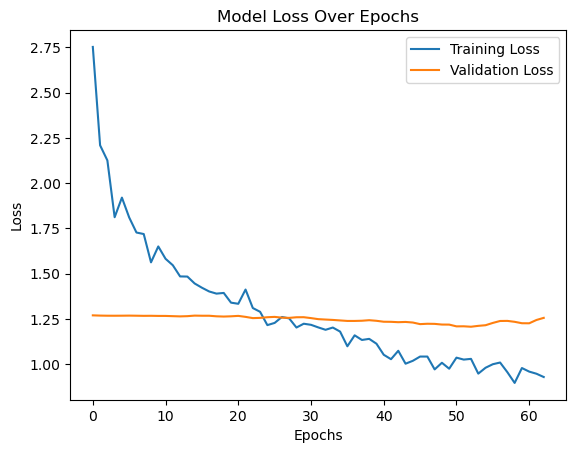

In [176]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 5) 

In [22]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-12 11:00:11,110] A new study created in memory with name: no-name-91fd14af-ce76-42da-b556-aa4e2eb3bd3e
[I 2024-11-12 11:00:18,640] Trial 0 finished with value: 1.5721849203109741 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.5721849203109741.
[I 2024-11-12 11:00:23,844] Trial 1 finished with value: 3.80015230178833 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.5721849203109741.
[I 2024-11-12 11:00:34,838] Trial 2 finished with value: 4.312074661254883 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2,

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.002714142252080901, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.0743422508239746


In [184]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.002714142252080901,
    'epochs': 150,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 2.2084 - val_loss: 1.1093
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5848 - val_loss: 1.0920
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4645 - val_loss: 1.0899
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4850 - val_loss: 1.0917
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2559 - val_loss: 1.0936
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3488 - val_loss: 1.0910
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3664 - val_loss: 1.0895
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1667 - val_loss: 1.0905
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2097 - val_loss: 1.0918
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1674 - val_loss: 1.0898
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1843 - val_loss: 1.0877
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2123 - val_loss: 1.0877


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
LSTM Model Performance:
Training RMSE: 0.02014859508135637
Test RMSE: 0.022906913325519
Training MAE: 0.01454627638546929
Test MAE: 0.01745026191331487
Directional Accuracy on Training Data: 59.58668197474167%
Directional Accuracy on Test Data: 60.66666666666667%


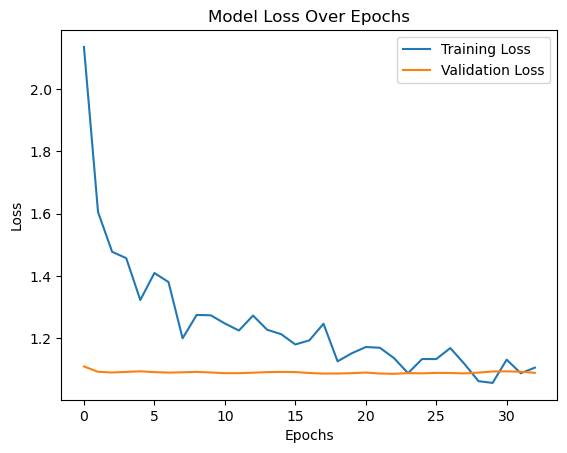

In [186]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 6) 

In [26]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 23s]
val_loss: 1.2789044380187988

Best val_loss So Far: 1.2789044380187988
Total elapsed time: 00h 07m 02s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.0218590046119431, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=64
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0218590046119431, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 64}
Best batch size: 64


In [200]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0218590046119431,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 7.1279 - val_loss: 3.4913
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4744 - val_loss: 3.4539
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8120 - val_loss: 3.4164
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3793 - val_loss: 3.3769
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0698 - val_loss: 3.3355
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7762 - val_loss: 3.2925
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6587 - val_loss: 3.2484
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4366 - val_loss: 3.2034
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3899 - val_loss: 3.1578
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2878 - val_loss: 3.1119
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1102 - val_loss: 3.0645
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1296 - val_loss: 3.0179


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.0199870640686132
Test RMSE: 0.023032343678605786
Training MAE: 0.014552114274983806
Test MAE: 0.017620315990267834
Directional Accuracy on Training Data: 52.81285878300803%
Directional Accuracy on Test Data: 56.00000000000001%


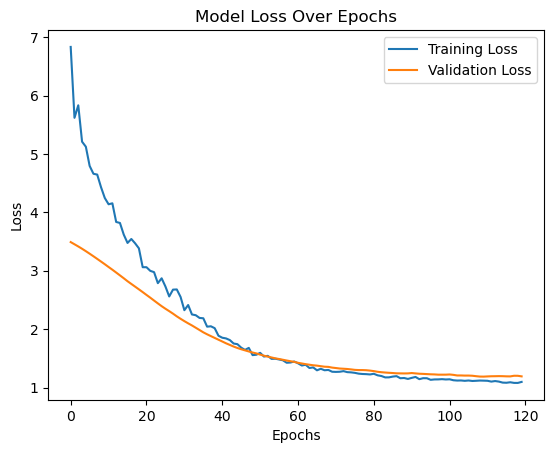

In [201]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation 

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |
| 5     | 0.020185       | 0.022906    | 0.014546       | 0.017450   | 59.6%                        | **60.7%**                   |
| 6     | 0.019987       | 0.023032    | 0.014552       | 0.017620   | 52.81%                        | 56.0%                       |


## Sequence Length = 12 

In [204]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 12  # Number of time steps used for target prediction, 12 weeks (Quarterly).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (864, 12, 5)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 5)
Reshaped  y_test_seq shape: (143, 1)


### 1. Random Search (Two Layers - Model 1)

In [32]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.68854558467865
Final Validation Loss: 1.7941575050354004
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.78792405128479
Final Validation Loss: 1.8863483667373657
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.4570540189743042
Final Validation Loss: 1.4287189245224
Running combination 4/30: {

In [206]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.2,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 2.7570 - val_loss: 1.1691
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1546 - val_loss: 1.1572
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9699 - val_loss: 1.1554
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8713 - val_loss: 1.1577
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7321 - val_loss: 1.1594
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7035 - val_loss: 1.1632
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6851 - val_loss: 1.1603
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6633 - val_loss: 1.1628
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4378 - val_loss: 1.1641
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5607 - val_loss: 1.1616
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5248 - val_loss: 1.1616
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3835 - val_loss: 1.1633
Epoch 13/50


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
LSTM Model Performance:
Training RMSE: 0.020400051301392157
Test RMSE: 0.0231930954238082
Training MAE: 0.014762719357510234
Test MAE: 0.01747941043951535
Directional Accuracy on Training Data: 52.02780996523755%
Directional Accuracy on Test Data: 52.816901408450704%


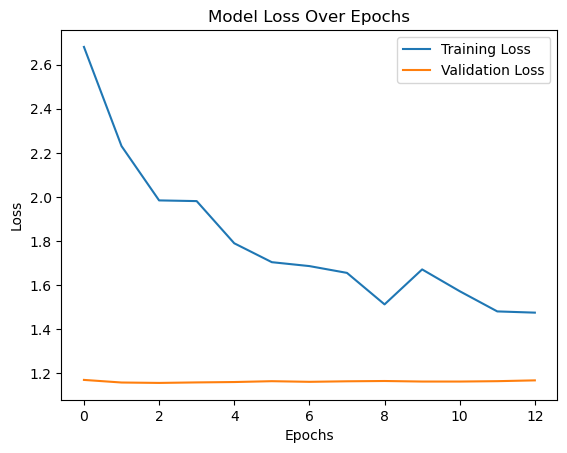

In [208]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [36]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0086045265197754
Final Validation Loss: 1.6518462896347046
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.176858901977539
Final Validation Loss: 4.096490383148193
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.260801076889038
Final Validat

In [210]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 4.6750 - val_loss: 1.3014
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.5007 - val_loss: 1.3014
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.3659 - val_loss: 1.3019
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2488 - val_loss: 1.2995
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.0852 - val_loss: 1.2985
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0120 - val_loss: 1.3026
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.8264 - val_loss: 1.3026
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.8974 - val_loss: 1.3002
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.6885 - val_loss: 1.3010
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7864 - val_loss: 1.3038
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6008 - val_loss: 1.3012
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.7691 - val_lo

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
LSTM Model Performance:
Training RMSE: 0.020429522640787286
Test RMSE: 0.023309933803253552
Training MAE: 0.01466967850085235
Test MAE: 0.01743404379202901
Directional Accuracy on Training Data: 48.783314020857475%
Directional Accuracy on Test Data: 50.0%


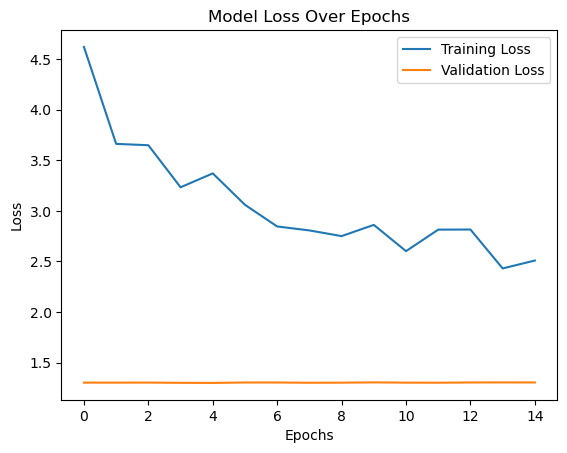

In [212]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [40]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-12 11:16:06,333] A new study created in memory with name: no-name-3209fd40-9291-48b0-bd5b-00ebea04666e
[I 2024-11-12 11:16:12,870] Trial 0 finished with value: 1.6677783727645874 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6677783727645874.
[I 2024-11-12 11:16:19,035] Trial 1 finished with value: 3.840607166290283 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.6677783727645874.
[I 2024-11-12 11:16:38,675] Trial 2 finished with value: 4.308155059814453 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0012240775718069888, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.0997122526168823


In [214]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0012240775718069888,
    'epochs': 150,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.3244 - val_loss: 1.1336
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7604 - val_loss: 1.1182
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7420 - val_loss: 1.1203
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6975 - val_loss: 1.1198
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4328 - val_loss: 1.1160
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4970 - val_loss: 1.1097
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3233 - val_loss: 1.1167
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5585 - val_loss: 1.1230
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3023 - val_loss: 1.1226
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4161 - val_loss: 1.1124
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3250 - val_loss: 1.1056
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3238 - val_loss: 1.1086


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
LSTM Model Performance:
Training RMSE: 0.020067693141061327
Test RMSE: 0.02321681888631882
Training MAE: 0.014603502794180514
Test MAE: 0.01749191427906337
Directional Accuracy on Training Data: 60.02317497103129%
Directional Accuracy on Test Data: 57.04225352112676%


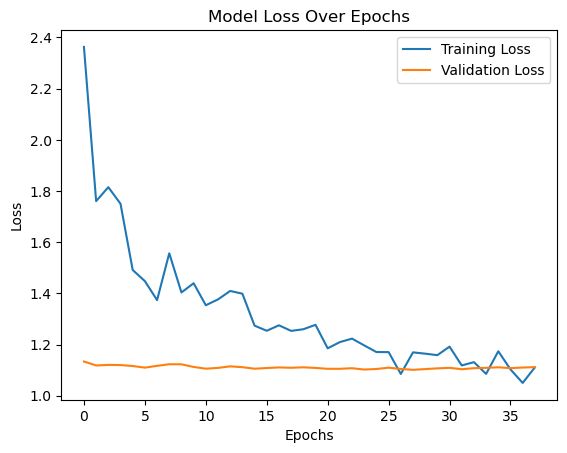

In [216]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [44]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 03s]
val_loss: 1.3014826774597168

Best val_loss So Far: 1.3014826774597168
Total elapsed time: 00h 06m 43s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.2, l2_lambda=0.001, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=5.0, units=32, num_layers=1, batch_size=32
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.2, 'l2_lambda': 0.001, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'batch_size': 32}
Best batch size: 32


In [218]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model
    
# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2405 - val_loss: 1.3087
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8115 - val_loss: 1.3033
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5926 - val_loss: 1.2997
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5462 - val_loss: 1.2990
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3853 - val_loss: 1.3041
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3453 - val_loss: 1.3159
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3528 - val_loss: 1.3134
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2184 - val_loss: 1.3142
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2222 - val_loss: 1.3318
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2066 - val_loss: 1.3309
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1057 - val_loss: 1.3501
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
LSTM Model Performance:
Training RMSE: 0.020476492418478345
Test RMSE: 0.023281786821013953
Training MAE: 0.014707478621401694
Test MAE: 0.017468277754463614
Directional Accuracy on Training Data: 46.581691772885286%
Directional Accuracy on Test Data: 57.04225352112676%


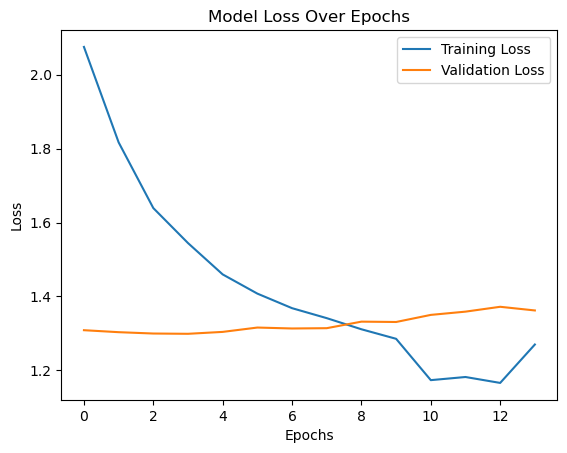

In [220]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |

## Sequence Length = 26 

In [222]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 26  # Number of time steps used for target prediction, 26 weeks (Six-Months).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (850, 26, 5)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 5)
Reshaped  y_test_seq shape: (129, 1)


### 1. Random Search (Two Layers - Model 1)

In [51]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.906967043876648
Final Validation Loss: 1.7449560165405273
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.219129800796509
Final Validation Loss: 1.9963220357894897
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.899275779724121
Final Validation Loss: 1.2382384538650513
Running combination 4/3

In [228]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.8781 - val_loss: 1.2098
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.6590 - val_loss: 1.1846
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.5223 - val_loss: 1.2177
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3167 - val_loss: 1.1912
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1273 - val_loss: 1.2013
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1042 - val_loss: 1.2494
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.0601 - val_loss: 1.2441
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6868 - val_loss: 1.2412
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7660 - val_loss: 1.2381
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7204 - val_loss: 1.2856
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7596 - val_loss: 1.3260
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.020538910486448403
Test RMSE: 0.024313514879194364
Training MAE: 0.014810016236999674
Test MAE: 0.01862381730703404
Directional Accuracy on Training Data: 57.36160188457008%
Directional Accuracy on Test Data: 55.46875%


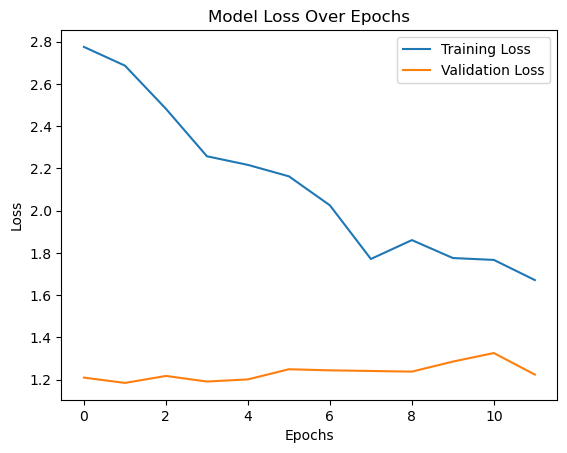

In [230]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [55]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0787794589996338
Final Validation Loss: 1.4564430713653564
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.176022052764893
Final Validation Loss: 4.013821601867676
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.7349512577056885
Final Valida

In [232]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 64,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 4.1529 - val_loss: 1.2033
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.8909 - val_loss: 1.2031
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6619 - val_loss: 1.1931
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7869 - val_loss: 1.1870
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4622 - val_loss: 1.1861
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2086 - val_loss: 1.1848
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3899 - val_loss: 1.1861
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3795 - val_loss: 1.1878
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1714 - val_loss: 1.1918
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2602 - val_loss: 1.1954
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3204 - val_loss: 1.1993
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM Model Performance:
Training RMSE: 0.020551923049568696
Test RMSE: 0.024270654285062795
Training MAE: 0.01510425821262852
Test MAE: 0.018508212480454415
Directional Accuracy on Training Data: 51.590106007067135%
Directional Accuracy on Test Data: 53.90625%


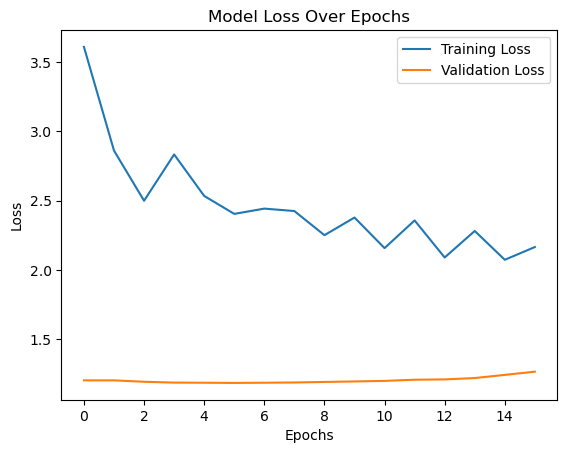

In [234]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [59]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-12 11:34:10,754] A new study created in memory with name: no-name-3cb7531c-84c6-4f2b-93e4-b185d17a3dcd
[I 2024-11-12 11:34:18,145] Trial 0 finished with value: 1.4179606437683105 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.4179606437683105.
[I 2024-11-12 11:34:26,089] Trial 1 finished with value: 3.978782892227173 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.4179606437683105.
[I 2024-11-12 11:34:46,293] Trial 2 finished with value: 5.994845867156982 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0011554791595316783, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 0.9598102569580078


In [252]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0011554791595316783,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9617 - val_loss: 1.0205
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6882 - val_loss: 0.9854
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7532 - val_loss: 1.0043
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4373 - val_loss: 0.9747
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5096 - val_loss: 0.9870
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2097 - val_loss: 0.9791
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2452 - val_loss: 0.9918
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1727 - val_loss: 0.9874
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2345 - val_loss: 1.0106
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1735 - val_loss: 1.0038
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2035 - val_loss: 1.0052
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Model Performance:
Training RMSE: 0.02049090151199721
Test RMSE: 0.024202665883877532
Training MAE: 0.014824705716491363
Test MAE: 0.018446662186742232
Directional Accuracy on Training Data: 63.60424028268551%
Directional Accuracy on Test Data: 64.84375%


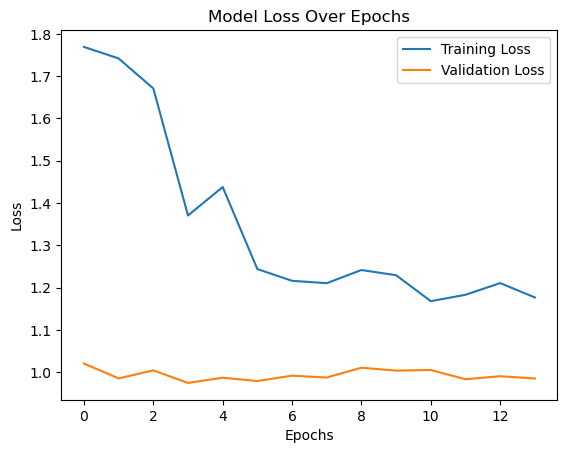

In [253]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [63]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 06s]
val_loss: 1.1726760864257812

Best val_loss So Far: 1.1726760864257812
Total elapsed time: 00h 09m 29s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.1, l2_lambda=0.0029343923926946802, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=64, num_layers=1, batch_size=120
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0029343923926946802, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 64, 'num_layers': 1, 'batch_size': 120}
Best batch size: 120


In [256]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 00.0029343923926946802,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.8447 - val_loss: 1.2412
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6957 - val_loss: 1.1935
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6915 - val_loss: 1.2109
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4072 - val_loss: 1.1834
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3855 - val_loss: 1.1809
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4130 - val_loss: 1.2066
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4127 - val_loss: 1.2005
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3875 - val_loss: 1.2036
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2930 - val_loss: 1.2272
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3312 - val_loss: 1.2046
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2877 - val_loss: 1.2099
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2525 - val_los

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.020436755690125378
Test RMSE: 0.02435714599002603
Training MAE: 0.014786491937594367
Test MAE: 0.018710137185414526
Directional Accuracy on Training Data: 59.59952885747939%
Directional Accuracy on Test Data: 58.59375%


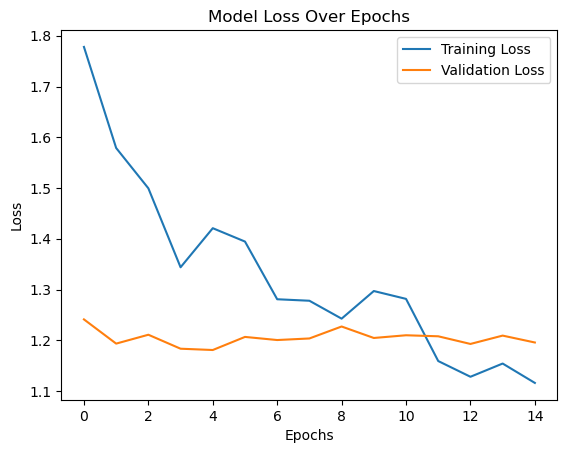

In [258]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |

## Sequence Length = 52

In [372]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 52  # Number of time steps used for target prediction, 52 weeks (One year).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (824, 52, 5)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 5)
Reshaped  y_test_seq shape: (103, 1)


### 1. Random Search (Two Layers - Model 1)

In [70]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.672315001487732
Final Validation Loss: 1.9968889951705933
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.5030605792999268
Final Validation Loss: 2.5075130462646484
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.7099303007125854
Final Validation Loss: 1.6403313875198364
Running combination 4

In [390]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 3.1909 - val_loss: 1.6266
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 2.7980 - val_loss: 1.6025
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 2.3747 - val_loss: 1.6063
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.1621 - val_loss: 1.6113
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 2.1667 - val_loss: 1.5911
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.0251 - val_loss: 1.6050
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0962 - val_loss: 1.5984
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.8677 - val_loss: 1.6024
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.8672 - val_loss: 1.5889
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 1.6251 - val_loss: 1.6086
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 1.7378 - val_loss: 1.5907
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122m

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM Model Performance:
Training RMSE: 0.020429778960547356
Test RMSE: 0.025069797989700295
Training MAE: 0.015164817761156774
Test MAE: 0.019387997304325996
Directional Accuracy on Training Data: 61.482381530984206%
Directional Accuracy on Test Data: 59.80392156862745%


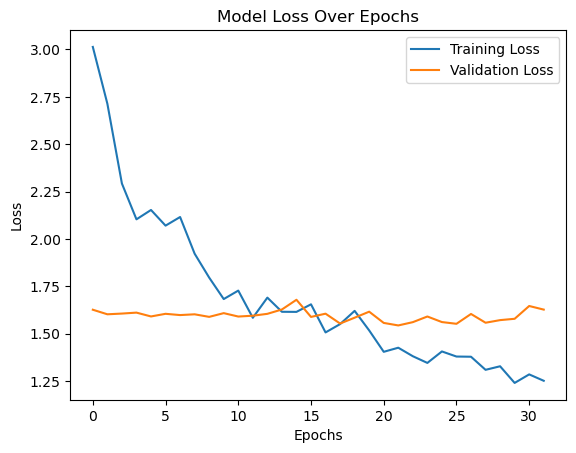

In [392]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [74]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0537693500518799
Final Validation Loss: 1.5788577795028687
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.270679950714111
Final Validation Loss: 4.273068428039551
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.810617446899414
Final Validat

In [402]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - loss: 3.2362 - val_loss: 1.7845
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 2.4524 - val_loss: 1.7658
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 2.3933 - val_loss: 1.7533
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 1.9966 - val_loss: 1.7824
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 2.1754 - val_loss: 1.7462
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 1.9346 - val_loss: 1.7610
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 1.8172 - val_loss: 1.7739
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 1.7901 - val_loss: 1.7441
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 1.8391 - val_loss: 1.7229
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 1.7131 - val_loss: 1.7738
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 1.7383 - val_loss: 1.7482
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM Model Performance:
Training RMSE: 0.02062496130136306
Test RMSE: 0.0257700212629079
Training MAE: 0.014903605937660236
Test MAE: 0.020212488417321397
Directional Accuracy on Training Data: 52.61239368165249%
Directional Accuracy on Test Data: 53.92156862745098%


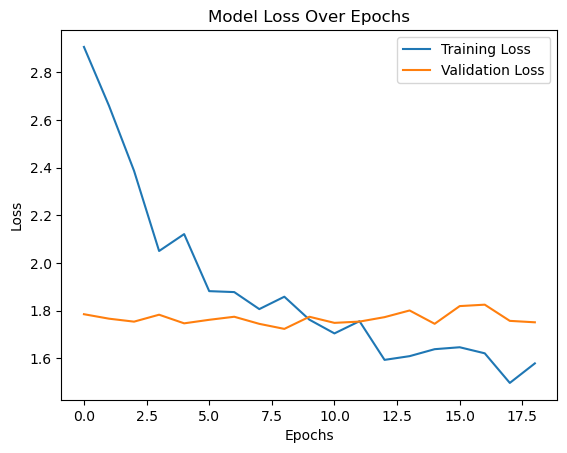

In [403]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [78]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.
    
    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-12 11:59:14,450] A new study created in memory with name: no-name-d6379542-7a33-4b89-ae83-580bfd6f208c
[I 2024-11-12 11:59:23,255] Trial 0 finished with value: 1.865431547164917 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.865431547164917.
[I 2024-11-12 11:59:34,241] Trial 1 finished with value: 4.173610210418701 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.865431547164917.
[I 2024-11-12 12:00:35,370] Trial 2 finished with value: 5.049676895141602 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, '

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0010171855559193877, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 100, 'batch_size': 64}
Best validation loss: 1.409308671951294


In [404]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010171855559193877,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Select the loss function based on tuning results.
    if params['loss_function'] == 'huber_loss':
        loss = Huber()  # Huber loss is more robust to outliers
    else:
        loss = MeanSquaredError()  # Use MSE as default loss function for regression
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 1.9887 - val_loss: 1.4403
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.6756 - val_loss: 1.4401
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.9348 - val_loss: 1.4537
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.3666 - val_loss: 1.4346
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.3473 - val_loss: 1.4492
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.3998 - val_loss: 1.4355
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.2918 - val_loss: 1.4357
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.2615 - val_loss: 1.4399
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2845 - val_loss: 1.4418
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.2594 - val_loss: 1.4364
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.2983 - val_loss: 1.4497
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM Model Performance:
Training RMSE: 0.020569201730511535
Test RMSE: 0.025666255611383904
Training MAE: 0.014946540505386114
Test MAE: 0.0201633785007319
Directional Accuracy on Training Data: 59.41676792223573%
Directional Accuracy on Test Data: 60.78431372549019%


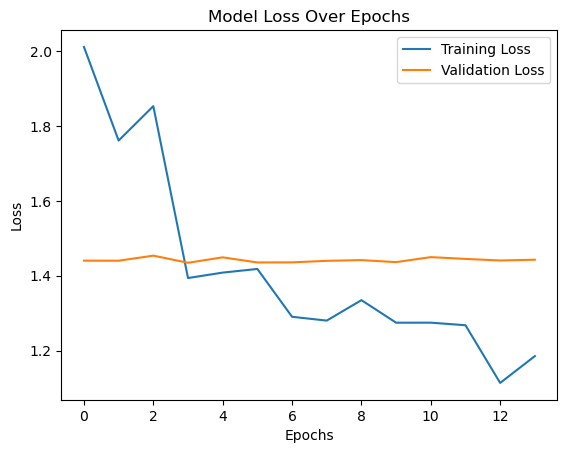

In [405]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [82]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 12s]
val_loss: 1.4193192720413208

Best val_loss So Far: 1.4193192720413208
Total elapsed time: 00h 17m 43s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size: 256


In [332]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 3.2269 - val_loss: 1.6458
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.1412 - val_loss: 1.6261
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.4844 - val_loss: 1.6338
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.3072 - val_loss: 1.6348
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.3157 - val_loss: 1.6304
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2.3536 - val_loss: 1.6259
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.0618 - val_loss: 1.6293
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.0086 - val_loss: 1.6265
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.1821 - val_loss: 1.6323
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.8754 - val_loss: 1.6364
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.1018 - val_loss: 1.6373
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.9244 - val_l

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.02057050495959062
Test RMSE: 0.025580470942135083
Training MAE: 0.014940840090374925
Test MAE: 0.02002691173210288
Directional Accuracy on Training Data: 63.06196840826246%
Directional Accuracy on Test Data: 64.70588235294117%


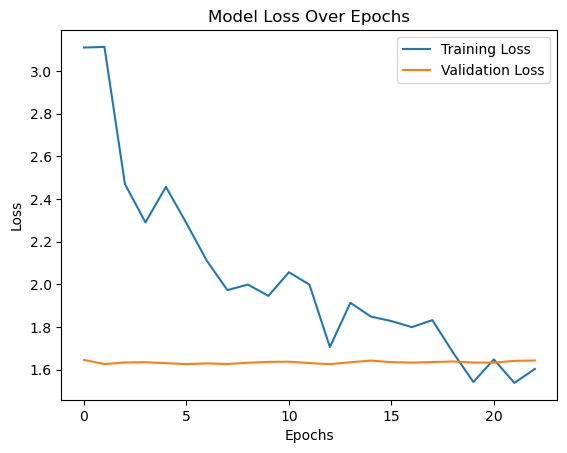

In [334]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |